\begin{center}
Chun-Yuan (Scott) Chiu
\end{center}
\begin{center}
chunyuac@andrew.cmu.edu
\end{center}

## Part 1

The data with index 278303 is BAC (Bank of America Corp) on 2017/3/21. Huge trading volume happened on that date. The below plot shows the time series of the total volume of BAC and SPY (an ETF tracking S\&P 500) and selected sector ETFs. In general there was a spike in volume on that date but the financials sector ETF XLF has by far the largest volume. Also, it can't be seen in this data but BAC was down almost 6\% on that date while S\&P 500 was only down 1.3\%. Most likely there were bad news in finance or even on BAC itself.

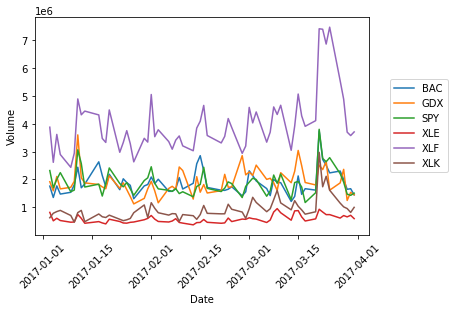

In [67]:
import matplotlib.pyplot as plt
import pandas as pd

fulldata = pd.read_csv('q1_2017_all.csv')
fulldata['Date'] = pd.to_datetime(fulldata['Date'], format='%Y%m%d')
fulldata['Volume'] = sum([fulldata[col] for col in fulldata.columns if '000' in col])

data = fulldata[fulldata['Ticker'].isin(['BAC', 'XLF', 'SPY', 'XLK', 'XLE', 'GDX'])][['Date', 'Ticker', 'Volume', 'VolatilityRank']]
ax = sns.lineplot(x='Date', y='Volume', hue='Ticker', data=data)
ax.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.xticks(rotation=45);

## Part 2

* As indicated below, there are 356 records on 13 variables.

In [72]:
import numpy as np
from pandas import DataFrame

fulldata = pd.read_csv('crsp_all.csv')
fulldata.shape

(356, 13)

* The below table shows that there are 4 different TICKERs but only 2 distinct CUSIP values, as the TICKER for CUSIP M7037810 has changed twice, once in August 2003 because the company changed its name and the other in December 2014 because of a [merger.](https://modernsystems.com/bluephoenix-and-ateras-complete-merger-operating-as-modern-systems/) 

In [81]:
idx = fulldata[['TICKER', 'CUSIP', 'COMNAM']].drop_duplicates().index
fulldata.iloc[idx, :]

,PERMNO,date,TICKER,COMNAM,CUSIP,BIDLO,ASKHI,PRC,VOL,BID,ASK,SHROUT,CFACPR
0,84415,20000929,CRYS,CRYSTAL SYSTEMS SOLUTIONS,M7037810,7.875,9.125,8.3125,3792,8.0625,8.4375,7000,0.25
35,84415,20030829,BPHX,BLUEPHOENIX SOLUTIONS LTD,M7037810,3.310,3.690,3.5400,296,3.3700,3.5400,13449,0.25
171,84415,20141231,MDSY,BLUEPHOENIX SOLUTIONS LTD,M7037810,3.200,3.750,3.4600,834,3.4600,3.5500,17844,1.00
172,84415,20150130,MDSY,MODSYS INTERNATIONAL LTD,M7037810,3.050,3.460,-3.0750,223,2.9500,3.2000,17844,1.00
178,85914,20000929,BBY,BEST BUY COMPANY INC,08651610,61.000,70.375,63.6250,322937,63.5000,63.6875,206755,2.25


* There are 4 different values of CFACPR and no missing data in this variable, as shown in the below table. 

In [4]:
fulldata['CFACPR'].drop_duplicates()

0      0.25
135    1.00
178    2.25
198    1.50
Name: CFACPR, dtype: float64

* One example where CFACPR is not 1 is as below: 

In [5]:
fulldata.iloc[178, :]

PERMNO                   85914
date                  20000929
TICKER                     BBY
COMNAM    BEST BUY COMPANY INC
CUSIP                 08651610
BIDLO                       61
ASKHI                   70.375
PRC                     63.625
VOL                     322937
BID                       63.5
ASK                    63.6875
SHROUT                  206755
CFACPR                    2.25
Name: 178, dtype: object

* Dividing PRC by CFACPR to form the adjusted price PRCadj, there is no missing data in PRCadj. 

In [82]:
fulldata['PRCadj'] = fulldata['PRC']/fulldata['CFACPR']
np.where(fulldata['PRCadj'].isna())

(array([], dtype=int64),)

* There are 178 unique dates.

In [7]:
np.unique(fulldata['date']).shape

(178,)

In [84]:
fulldata[(fulldata['PRCadj'] < 0) & (fulldata['date']//10000 == 2014)]

,PERMNO,date,TICKER,COMNAM,CUSIP,BIDLO,ASKHI,PRC,VOL,BID,ASK,SHROUT,CFACPR,PRCadj
164,84415,20140530,BPHX,BLUEPHOENIX SOLUTIONS LTD,M7037810,4.1000,4.30,-4.100,260,4.05,4.15,11468,1.0,-4.100
168,84415,20140930,BPHX,BLUEPHOENIX SOLUTIONS LTD,M7037810,3.5501,3.81,-3.595,130,3.50,3.69,11621,1.0,-3.595


* Daily market data found in WRDS shows that on these two dates BPHX has zero volume and hence no closing price, in which case CRSP data uses a negative average of the bid and the ask prices as the closing price, as explained [here](https://libguides.eur.nl/edsc-manuals/blog/Why-is-the-stock-price-in-CRSP-preceded-by-a-minus-sign).

In [87]:
daily = pd.read_csv('crsp_daily.csv')
daily[(daily['CUSIP']=='M7037810') & (daily['date'].isin([20140930, 20140530]))]

,PERMNO,date,TICKER,COMNAM,CUSIP,PRC,VOL
3454,84415,20140530,BPHX,BLUEPHOENIX SOLUTIONS LTD,M7037810,-4.100,0
3539,84415,20140930,BPHX,BLUEPHOENIX SOLUTIONS LTD,M7037810,-3.595,0


* There was one record where the closing bid is larger than the closing ask, known as a crossed market. According to [this paper](http://faculty.bus.olemiss.edu/rvanness/Accepted%20Papers/L&C-JFM.pdf), in early 2000s crossed markets happen from time to time but only last for a few seconds before they are arbitraged away. A crossed market can happen when two market makers in different trading venues post bid and ask prices at around the same time, where one's bid is larger than the other's ask. In our data the crossed market is a closing bid/ask prices. Most likely it happened a few seconds before closing and before anyone saw the arbitrage opportunity the market was closed. 

In [89]:
fulldata['PRCadj'] = np.abs(fulldata['PRCadj'])
fulldata['PRC'] = np.abs(fulldata['PRC'])
fulldata[fulldata['BID'] > fulldata['ASK']]

,PERMNO,date,TICKER,COMNAM,CUSIP,BIDLO,ASKHI,PRC,VOL,BID,ASK,SHROUT,CFACPR,PRCadj
252,85914,20061130,BBY,BEST BUY COMPANY INC,08651610,51.39,55.84,54.97,1045295,54.92,54.91,480250,1.0,54.97


* From the below plot we see that, when stock prices are going to drop next month, the distribution of momentum is slightly skewed to the right. This is more obvious when compared to the momentum distribution when stock prices are going to go up next month. 

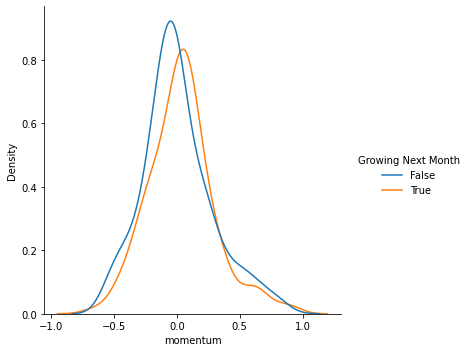

In [90]:
%matplotlib inline
import seaborn as sns

dfs = []
for cusip, data in fulldata.groupby(['CUSIP']):
    data['momentum'] = data['PRCadj'].rolling(5).apply(lambda df: df.iloc[-2]/df.iloc[-5] - 1)
    data['Growing Next Month'] = (data['PRCadj'].shift(-1)) > data['PRCadj']
    dfs.append(data)

fulldata = pd.concat(dfs, ignore_index=True)
sns.displot(fulldata, x='momentum', hue='Growing Next Month', kind='kde')
